In [123]:
import pandas
import numpy
from RexR import *
import _helpers
Rocket = RexR(datalocation = None, #'_data/genomic_data/data.pkl', 
              seed = 3123, 
              debug = False, 
              write_out=True) 
Rocket.load_probeset_data();

%matplotlib inline
%load_ext autoreload
%autoreload 2

++++++++++++++++++++++++++++++ Firing up RexR! ++++++++++++++++++++++++++++++
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from math import*
#from scipy.dspatial.distance import cosine
from scipy.spatial.distance import minkowski
from scipy.spatial.distance import cdist
from decimal import Decimal
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from time import time
from sklearn.cluster import AffinityPropagation
import matplotlib.pyplot as plt
from itertools import cycle

In [3]:
TransPosed = Rocket.DATA_all_samples.T # all microarrays, may be multiple per patient versus all probesets, may be multiple per genome
Normal = Rocket.DATA_all_samples
AllNormal = Rocket.DATA_merged
#probeset_weights = Rocket.get_probeset_weights(method = )

In [4]:
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.cross_decomposition import CCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Patient clustering

## Markov clustering

In [10]:
patient_sim = _helpers.patient_similarity(Normal, sim_type = 'cosine', normalised = True, inflation = 2, minkowski_dim=1)
##### apply Markov clustering
#######################
# non-distributed, non-sparse version, only for small-sized problems (N is order 1000)
e = 2
r = 2 
epsilon = 1e-7
convergence = 0.001
num_iter = 10
Orientation = 'col' # columnwise or rowwise

# add loop
def add_loop(df_matrix, value=0): 
    for i in df_matrix.index:
        df_matrix.loc[i, i] = value
    return df_matrix
patient_sim = add_loop(patient_sim, 1)
patient_sim = patient_sim - epsilon

def normalise(sim, type = 'col'):
    if(type == 'col'):
        # column normalisation
        for variable in sim.keys():
            col_vec = sim[variable]
            sum_val = sum([p for p in col_vec])
            sim[variable] = sim[variable]/sum_val
    elif (type == 'row'):
        # row normalisation
        for variable in sim.keys():
            row_vec = sim.loc[variable, :]
            sum_val = sum([p for p in row_vec])
            sim.loc[variable,:] = sim.loc[variable,:]/sum_val
    return sim

# step E: expansion, get the nth power of the matrix
def expansion(sim):
    X = numpy.array(sim)
    VarList = sim.keys()
    if e == 1:
        return sim
    elif e > 1:        
        return pandas.DataFrame(numpy.linalg.matrix_power(X, e), index = VarList, columns = VarList)
     
# step I: inflation, per column raise by rth power and column normalise
def inflation(sim, type = 'col'):    
    if type == 'col':
        Axis = 0
    elif type == 'row':
        Axis = 1
    return sim.apply(lambda x: x**r/sum(x**r), axis = Axis)

# remove weak connections, values < epsilon
def clean(sim):
    return sim.applymap(lambda x:0 if x<epsilon else x)
    
def difference(old, new):
    # relative zeroes over entire array
    #return (new.apply(lambda x: numpy.ceil(x-epsilon)) - old.apply(lambda x: numpy.ceil(x-epsilon))).sum().sum()/len(old)**2    
    return abs(new - old).sum().sum()/len(old)**2    

#patient_sim = normalise(patient_sim, type = Orientation)
_sim_a = patient_sim
for i in range(0,num_iter):
    # repeat E and I until convergence, the row-wise elements form the clusters.
    _sim_b = clean(inflation(expansion(_sim_a), type = Orientation))
    _sim_a = normalise(_sim_a, type = Orientation)
    #if ((difference(_sim_a, _sim_b)) < convergence) & (i>0):
    #    print(difference(_sim_a, _sim_b))
    #    print("CONVERGED after ", i, " iterations")
    #    break;
    _sim_a = _sim_b

result_mcl = clean(_sim_b)
result_mcl.loc[result_mcl.loc['9827_corr2.CEL',:]>epsilon, '9827_corr2.CEL']

Series([], Name: 9827_corr2.CEL, dtype: float64)

In [93]:
patient_sim = _helpers.patient_similarity(Normal, sim_type = 'euclidian', normalised = True, inflation=2, minkowski_dim=1)
##### apply Affinity Propagation
#######################
X = numpy.array(patient_sim)
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
n_clusters = len(cluster_centers_indices)
patient_clusters = patient_sim.keys()[cluster_centers_indices].values
patient_cluster_members = af.labels_
print("There are {} patient clusters".format(n_clusters))

There are 4 patient clusters


In [94]:
AggResults = Rocket.DATA_merged
AggResults = _helpers._preprocess(AggResults)
#AggResults = _helpers._group_patients(AggResults, method = 'mean')
AggResults['cluster_ap'] = patient_cluster_members

#AggResults.groupby(['Treatment risk group in ALL10', 'cluster_ap']).agg({'Microarray file': pandas.Series.nunique})


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [95]:
AggResults['FU_RFS'] = pandas.to_numeric(AggResults['FU_RFS'])
AggResults['FU_EFS'] = pandas.to_numeric(AggResults['FU_EFS'])
AggResults['FU_OS'] = pandas.to_numeric(AggResults['FU_OS'])
AggResults['WhiteBloodCellcount'] = pandas.to_numeric(AggResults['WhiteBloodCellcount'])
AggResults['Age'] = pandas.to_numeric(AggResults['Age'])
AggResults['Gender'] = pandas.to_numeric(AggResults['Gender'])
AggResults['code_RFS']= pandas.to_numeric(AggResults['code_RFS'])
AggResults['code_EFS']= pandas.to_numeric(AggResults['code_EFS'])
AggResults['code_OS']= pandas.to_numeric(AggResults['code_OS'])

AggResults['mutations_NOTCH_pathway'] = pandas.to_numeric(AggResults['mutations_NOTCH_pathway'])
AggResults['mutations_PTEN_AKT_pathway'] = pandas.to_numeric(AggResults['mutations_PTEN_AKT_pathway'])
AggResults['mutations_IL7R_pathway'] = pandas.to_numeric(AggResults['mutations_IL7R_pathway'])
#AggResults.replace(to_replace=9999, value=0.5, inplace=True)
AggResults[['mutations_NOTCH_pathway', 
            'mutations_PTEN_AKT_pathway', 
            'mutations_IL7R_pathway']] = AggResults[['mutations_NOTCH_pathway', 
                                                    'mutations_PTEN_AKT_pathway', 
                                                    'mutations_IL7R_pathway']].replace([9999],[numpy.nan],
                                                                                       inplace=False)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [96]:
AggResults['comb_mutations_NOTCH_IL7R'] = AggResults['mutations_NOTCH_pathway'] + AggResults['mutations_IL7R_pathway']
AggResults['comb_mutations_NOTCH_PTEN'] = AggResults['mutations_NOTCH_pathway'] + AggResults['mutations_PTEN_AKT_pathway']
AggResults['comb_mutations_IL7R_PTEN'] =  AggResults['mutations_PTEN_AKT_pathway'] + AggResults['mutations_IL7R_pathway']
AggResults['comb_mutations_IL7R_PTEN_NOTCH'] =  AggResults['mutations_PTEN_AKT_pathway']\
                                                + AggResults['mutations_IL7R_pathway']\
                                                + AggResults['mutations_NOTCH_pathway']


patient_count = AggResults.groupby(['cluster_ap']).agg({'labnr_patient': pandas.Series.nunique})
Clustered_by_patients_whitebloodcells = AggResults[AggResults['WhiteBloodCellcount'].apply(lambda x: isnan(x) is False)].groupby(['cluster_ap']).agg(
    {'WhiteBloodCellcount': numpy.mean,
    'Age': numpy.mean, 
    'Gender': numpy.mean})

# Cancer_gene
# Treatment_protocol
# Treatment_risk_group_in_ALL_10

Clustered_by_patients_CODE = AggResults.groupby(['cluster_ap']).agg(
    {'code_RFS': numpy.mean, 
     'code_EFS': numpy.mean,
     'code_OS': numpy.mean})

Clustered_by_patients_FU_RFS = AggResults[AggResults['FU_RFS'].apply(lambda x: isnan(x) is False)].groupby(['cluster_ap']).agg(
    {'FU_RFS': numpy.median, 
     'FU_EFS': numpy.median,
     'FU_OS': numpy.median})
Clustered_by_patients_NotchPath = AggResults[AggResults['mutations_NOTCH_pathway'].apply(lambda x: isnan(x) is False)].groupby(['cluster_ap']).agg(
    {'mutations_NOTCH_pathway': numpy.mean})
Clustered_by_patients_IL7RPath = AggResults[AggResults['mutations_IL7R_pathway'].apply(lambda x: isnan(x) is False)].groupby(['cluster_ap']).agg(
    {'mutations_IL7R_pathway': numpy.mean})
Clustered_by_patients_PTENAKTPath = AggResults[AggResults['mutations_PTEN_AKT_pathway'].apply(lambda x: isnan(x) is False)].groupby(['cluster_ap']).agg(
    {'mutations_PTEN_AKT_pathway': numpy.mean})
Clustered_by_patients_comb_NOTCH_IL7R = AggResults[AggResults['comb_mutations_NOTCH_IL7R'].apply(lambda x: isnan(x) is False)].groupby(['cluster_ap']).agg(
    {'comb_mutations_NOTCH_IL7R': numpy.mean})
Clustered_by_patients_comb_NOTCH_PTEN = AggResults[AggResults['comb_mutations_NOTCH_PTEN'].apply(lambda x: isnan(x) is False)].groupby(['cluster_ap']).agg(
    {'comb_mutations_NOTCH_PTEN': numpy.mean})
Clustered_by_patients_comb_IL7R_PTEN = AggResults[AggResults['comb_mutations_IL7R_PTEN'].apply(lambda x: isnan(x) is False)].groupby(['cluster_ap']).agg(
    {'comb_mutations_IL7R_PTEN': numpy.mean})
Clustered_by_patients_comb_IL7R_PTEN_NOTCH = AggResults[AggResults['comb_mutations_IL7R_PTEN_NOTCH'].apply(lambda x: isnan(x) is False)].groupby(['cluster_ap']).agg(
    {'comb_mutations_IL7R_PTEN_NOTCH': numpy.mean})


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [113]:
Clustered_by_patients_comb_IL7R_PTEN

,comb_mutations_IL7R_PTEN
cluster_ap,
0,0.500000
1,0.553191
2,0.300000
3,0.657895


Cluster centers: ['KGK_Tall_JL_7418.CEL' 'KGK_Tall_JL_7743.CEL' '2780.CEL' '8639.CEL']
[3 3 3 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 1 1 0 1 1 1 1
 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 3 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 3 1 3 1
 1 1 1 1 3 1 1 3 3 3 3 3 1 3 2 3 2 2 3 3 1 3 3 3 3 3 3 2 2 2 3 3 3 1 3 2 3
 3 2 3 3 3 3 3 2 3 2 3 3 1 3 3 2 3 3 2 2 2 3 3 2 3 3 3 3 3 3 3 1 0 1 3 3 3
 3 3 2 3 2 3 3 3 3 2 1 3 2 3 3 1 1 3 3 3 3 3 3 3 1 3 1 3 1 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 3 1 1 1
 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 3 1 1 1 1 1 1 1 3 1 3 1 1 1 1 0 0 0 1 1 0 1
 1 1 1 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 3 1 1 1 0 1 3 1 0 0 0 1 0 1 1 1 0 1 0
 0 0 1 1 1 1 0 0 3 1 0 0 0 3 0]


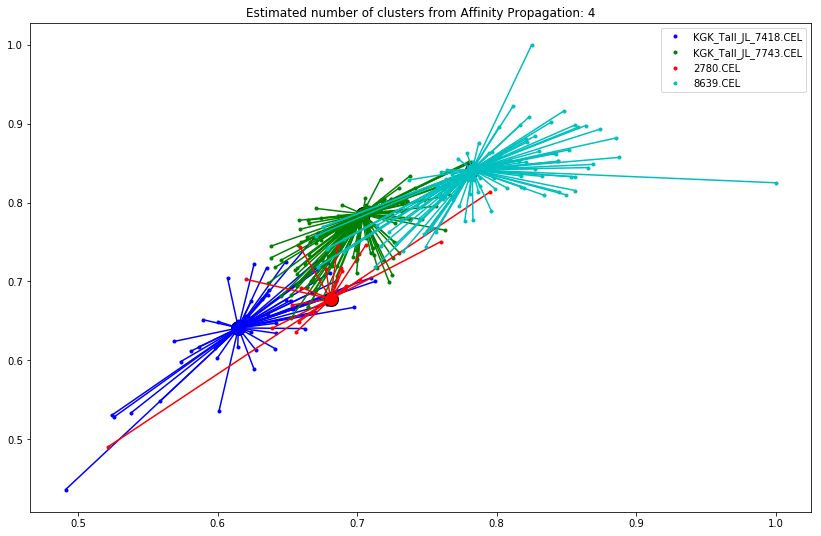

In [104]:
print("Cluster centers:",patient_sim.keys()[cluster_centers_indices].values)
print(patient_cluster_members)

plt.close('all')
plt.figure(figsize=(14,9))
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters), colors):
    class_members = patient_cluster_members == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.', 
             label = patient_sim.keys()[cluster_centers_indices[k]])
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.legend()
        
plt.title('Estimated number of clusters from Affinity Propagation: %d' % n_clusters)
plt.show()

In [19]:
##### CREATE graph from similarity matrix
##################
# nodes
VarList = TransPosed.keys()
nodes = []
node_index = 0
for patient_name in VarList:
    nodes.append((node_index, {'name': patient_name}))
    node_index = node_index + 1

edges = []
# edges
patient_sim = patient_similarity(Normal, sim_type = 'pearson', normalised = True, inflation=2)
node_index_x = 0
node_index_y = 0
for patient_name_x in VarList:
    for patient_name_y in VarList:        
        edges.append((node_index_x, node_index_y, patient_sim.iloc[node_index_x, node_index_y]))
        node_index_y = node_index_y + 1
    node_index_x = node_index_x + 1
    node_index_y = 0

In [20]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges, weight = 'weight')

c:\users\bramva~1\envs\worken~1\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
c:\users\bramva~1\envs\worken~1\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
c:\users\bramva~1\envs\worken~1\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
c:\users\bramva~1\envs\worken~1\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is de

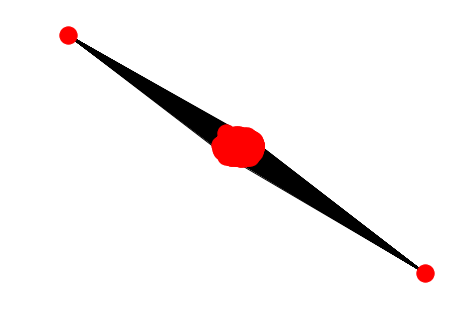

In [23]:
##### apply Spring-force
#######################
pos = nx.spring_layout(G, k = None, dim = 3, scale = 1.0)
nx.draw_spring(G, k = 30, dim = 2, scale = 1.0, iterations =1500)
plt.show()

In [ ]:
##### APPLY community detector
# maximize betweenness and modularity
##################################


In [12]:
##### LOAD IN DATA
###################
# https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns
# 

In [124]:
df = _helpers._preprocess(Rocket.DATA_merged) 
df = _helpers._group_patients(df, method = 'mean')

In [125]:
x,y =_helpers._get_matrix(df, features = 'genomic', target = 'Treatment_risk_group_in_ALL10')

+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


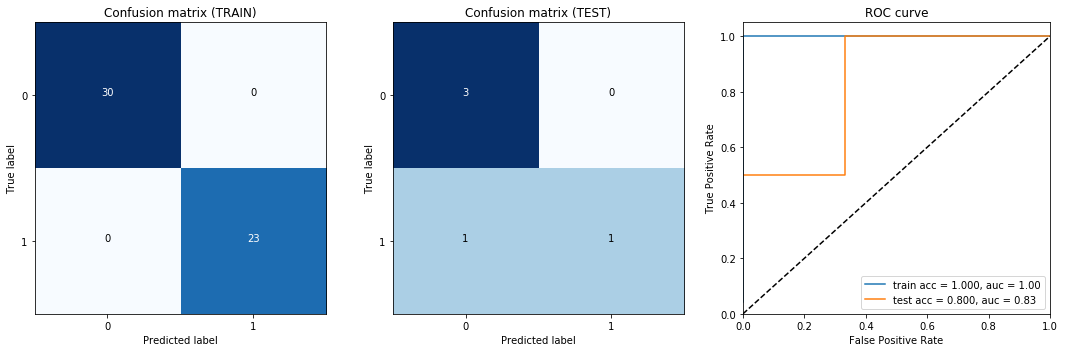

MODEL: RF accuracy:  0.51724137931 +/-: 0.017683030406
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.55      0.82      0.66        33
          1       0.33      0.12      0.18        25

avg / total       0.46      0.52      0.45        58

++++++++++++++++++++++++++++++++++++++++++++++++++


In [156]:
preds, class_model = Rocket.classify_treatment(model_type = 'RandomForest', 
                                              features = 'genomic',
                                              parameters = {},
                                              pipeline = {"scaler": {"type": "minmax"},
                                                          "pre_processing": {"patient_grouping": 'mean', 
                                                                             "bias_removal": False},
                                                          "dim_reduction": {"type": "PCA", "n_comp": 1000},
                                                          "feature_selection": {"type": "RFECV", "top_n": 100}})

In [154]:
preds

array([[ 0.51712781,  0.48287219],
       [ 0.67036444,  0.32963556],
       [ 0.64254908,  0.35745092],
       [ 0.63734117,  0.36265883],
       [ 0.64763569,  0.35236431],
       [ 0.56252983,  0.43747017],
       [ 0.57160406,  0.42839594],
       [ 0.57003459,  0.42996541],
       [ 0.56770642,  0.43229358],
       [ 0.62596044,  0.37403956],
       [ 0.548906  ,  0.451094  ],
       [ 0.6287963 ,  0.3712037 ],
       [ 0.62476872,  0.37523128],
       [ 0.58375777,  0.41624223],
       [ 0.55748162,  0.44251838],
       [ 0.58997576,  0.41002424],
       [ 0.62212209,  0.37787791],
       [ 0.51348898,  0.48651102],
       [ 0.6277794 ,  0.3722206 ],
       [ 0.60299306,  0.39700694],
       [ 0.6363615 ,  0.3636385 ],
       [ 0.64677509,  0.35322491],
       [ 0.61974766,  0.38025234],
       [ 0.53742613,  0.46257387],
       [ 0.63268089,  0.36731911],
       [ 0.63973311,  0.36026689],
       [ 0.60385879,  0.39614121],
       [ 0.66923553,  0.33076447],
       [ 0.65886679,

In [14]:
preds = [pred_[1]for pred_ in preds]
#len(Rocket.DATA_merged[Rocket.DATA_merged["array-batch"].isin(["cohort 1", "cohort 2", "JB", "IA", "ALL-10"])])
Results = Rocket.DATA_merged_processed
Results['pred'] = preds
print(Results[:311][['labnr_patient', 'pred', 'Treatment_risk_group_in_ALL10']])

IndexError: invalid index to scalar variable.